In [1]:
!pip install snntorch -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 48.8 MB/s eta 0:00:00


In [2]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

from tqdm import tqdm

<ipython-input-2-bd886847109b>:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


## Data and dataloaders

In [3]:
batch_size = 64
data_path_c='/tmp/data/cifar10'
data_path_m='/tmp/data/mnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
transform = transforms.Compose([
                              #  transforms.Resize((28, 28)), # for MNIST
                               transforms.Resize((32, 32)), # for CIFAR10
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0), (1))
                              ])


# for MNIST

# mnist_train = datasets.MNIST(data_path_m, train=True, download=True, transform=transform)
# mnist_test = datasets.MNIST(data_path_m, train=False, download=True, transform=transform)

# train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)


# for CIFAR10

cifar_train = datasets.CIFAR10(data_path_c, train=True, download=True, transform=transform)
cifar_test = datasets.CIFAR10(data_path_c, train=False, download=True, transform=transform)

train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 61387163.84it/s]


Extracting /tmp/data/cifar10/cifar-10-python.tar.gz to /tmp/data/cifar10
Files already downloaded and verified


## Defining the network

In [7]:
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
num_steps = 50

net = nn.Sequential(nn.Conv2d(1, 32, 3),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(32, 32, 3),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),

                    nn.Conv2d(32, 64, 3),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(64, 64, 3),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2),

                    nn.Flatten(),
                    nn.Linear(1600, 10), # for CIFAR10
                    # nn.Linear(1024, 10), # for MNIST
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)

                    ).to(device)

## Forward pass

In [10]:
def forward_pass(net, num_steps, data):
    mem_rec = []
    spk_rec = []
    utils.reset(net)  # resets hidden states for all LIF neurons in net

    for step in range(num_steps):
        spk_out, mem_out = net(data)
        spk_rec.append(spk_out)
        mem_rec.append(mem_out)

    return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)

spk_rec, mem_rec = forward_pass(net, num_steps, data)

## Batch accuracy function

In [11]:
def batch_accuracy(test_loader, net, num_steps):
    with torch.no_grad():
        total = 0
        acc = 0
        net.eval()

        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            spk_rec, _ = forward_pass(net, num_steps, data)

            acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
            total += spk_rec.size(1)

    return acc/total

## Training Loop

In [14]:
torch.cuda.empty_cache()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999))
loss_fn = nn.CrossEntropyLoss()
num_epochs = 5 # actually 16 epochs were trained iteratively
loss_hist = []
test_loss_hist = []
test_acc_hist = []
counter = 0

for epoch in range(num_epochs):
    iter_counter = 0

    for data, targets in tqdm(iter(train_loader)):
        data = data.to(device)
        targets = targets.to(device)

        net.train()
        spk_rec, mem_rec = forward_pass(net, num_steps, data)

        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss_fn(mem_rec[step], targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        loss_hist.append(loss_val.item())

    with torch.no_grad():
        net.eval()
        test_acc = batch_accuracy(test_loader, net, num_steps)
        print(f"Epoch {epoch} Test acc: {test_acc * 100:.2f}%\n")
        test_acc_hist.append(test_acc.item())

100%|██████████| 781/781 [04:24<00:00,  2.95it/s]


Epoch 0 Test acc: 33.56%



100%|██████████| 781/781 [04:23<00:00,  2.96it/s]


Epoch 1 Test acc: 43.78%



100%|██████████| 781/781 [04:23<00:00,  2.96it/s]


Epoch 2 Test acc: 53.46%



100%|██████████| 781/781 [04:24<00:00,  2.95it/s]


Epoch 3 Test acc: 57.12%



100%|██████████| 781/781 [04:23<00:00,  2.96it/s]


Epoch 4 Test acc: 60.42%



## Saving the model

In [27]:
torch.save(net.state_dict(), 'DL_model_16e.pth')

## Plotting accuracy

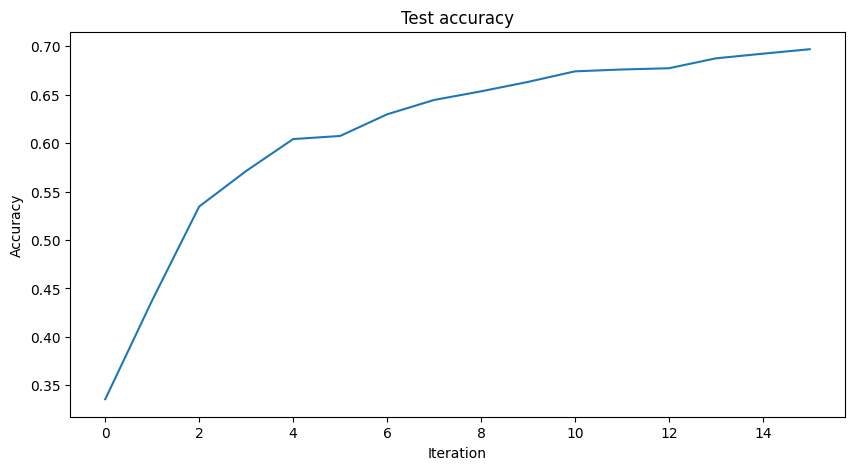

In [24]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(test_acc_hist)
plt.title("Test accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()